In [1]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mb_size = 64

transform = transforms.ToTensor()

trainData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)

trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=mb_size)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
dataIter = iter(trainLoader)

imgs, labels = dataIter.next()

In [4]:
imgs.shape

torch.Size([64, 1, 28, 28])

In [5]:
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

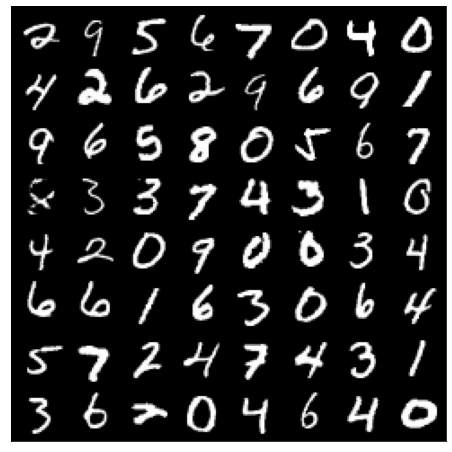

In [6]:
imshow(imgs)

In [7]:
Z_dim = 100
H_dim = 128
X_dim = imgs.view(imgs.size(0), -1).size(1)

print(Z_dim, H_dim, X_dim)

device = 'cuda'

100 128 784


In [8]:
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #nn.Conv1d(Z_dim, H_dim, 4),
            nn.Linear(Z_dim, H_dim),
            nn.ReLU(),
            #nn.Conv1d(H_dim, X_dim, 4),
            nn.Linear(H_dim, X_dim),
            nn.Sigmoid()
        )
          
    def forward(self, input):
        return self.model(input)

In [9]:
G = Gen().to(device)

In [10]:
class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #nn.Conv1d(X_dim, H_dim, 4),
            nn.Linear(X_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, 1),
            #nn.Conv1d(H_dim, 1, 4),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.model(input)

In [11]:
D = Dis().to(device)

In [12]:
print(G)
print(D)

Gen(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Dis(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [13]:
lr = 1e-3

g_opt = opt.Adam(G.parameters(), lr=lr)
d_opt = opt.Adam(D.parameters(), lr=lr)

Epoch:0,   G_loss:4.945670621354442,    D_loss:0.13351536571913994


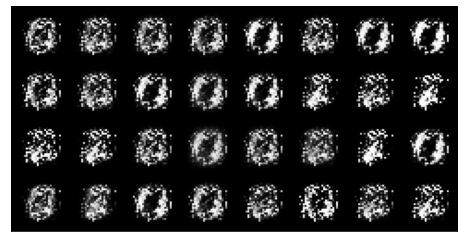

Epoch:1,   G_loss:4.327445693361733,    D_loss:0.09284372428364591


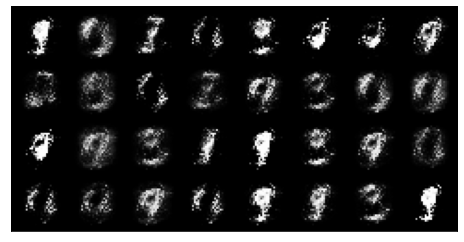

Epoch:2,   G_loss:4.097313356297865,    D_loss:0.177416665068488


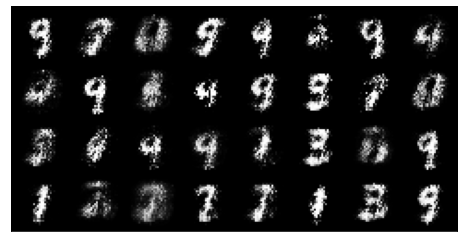

Epoch:3,   G_loss:4.17394434261932,    D_loss:0.3008287203257907


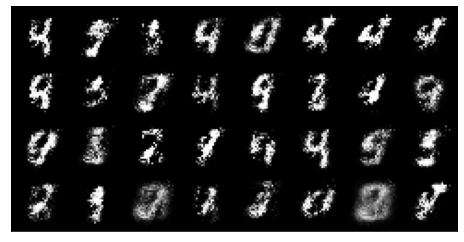

Epoch:4,   G_loss:3.833411705773522,    D_loss:0.400302695789571


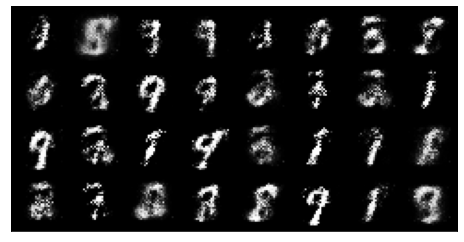

Epoch:5,   G_loss:3.1598972240999057,    D_loss:0.5362416383172912


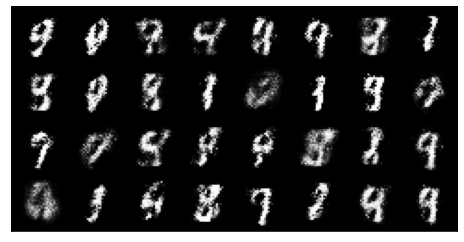

Epoch:6,   G_loss:2.8603626651042053,    D_loss:0.6277171350173605


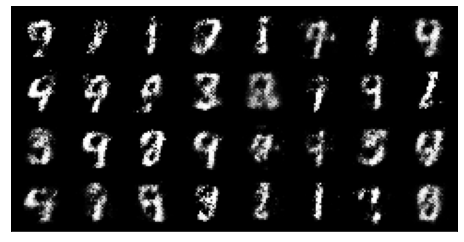

Epoch:7,   G_loss:2.7051697795324996,    D_loss:0.7082234837098925


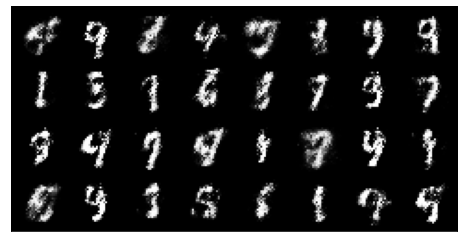

Epoch:8,   G_loss:2.859522114684587,    D_loss:0.7143099279418937


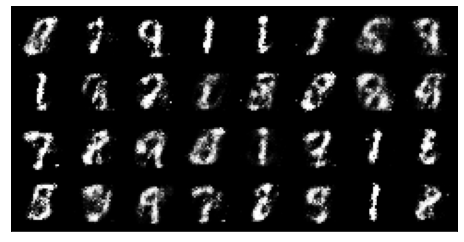

Epoch:9,   G_loss:2.473754711878071,    D_loss:0.7854741854644788


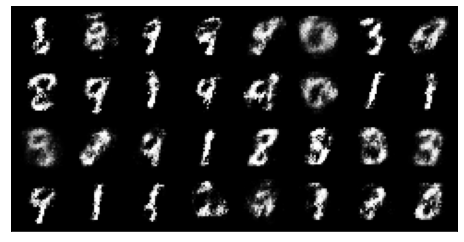

Epoch:10,   G_loss:2.3347278384765837,    D_loss:0.8760321559364608


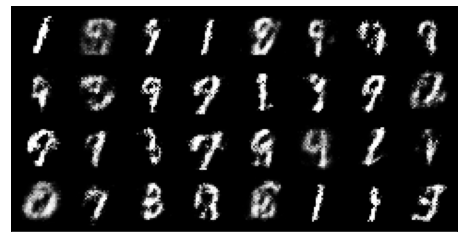

Epoch:11,   G_loss:2.132951223138553,    D_loss:0.9090283059044433


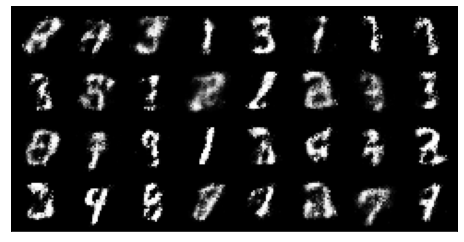

Epoch:12,   G_loss:2.0633871101621373,    D_loss:0.9198441820294618


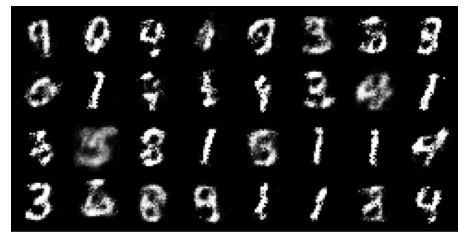

Epoch:13,   G_loss:2.0224668539917547,    D_loss:0.9063234790238236


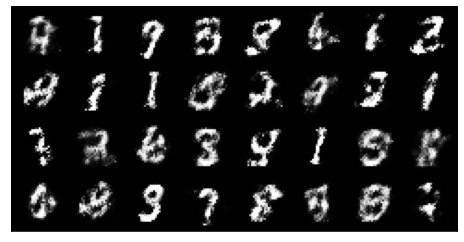

Epoch:14,   G_loss:1.8806683676583427,    D_loss:0.9337867076463028


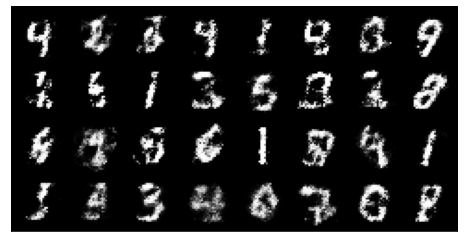

Epoch:15,   G_loss:1.8034527092091819,    D_loss:0.9538285283645841


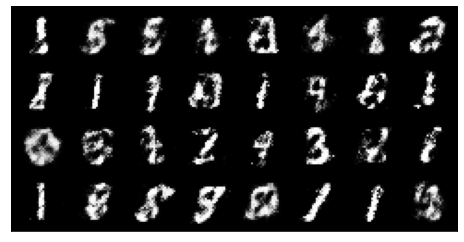

Epoch:16,   G_loss:1.749432269062823,    D_loss:0.9394455743369772


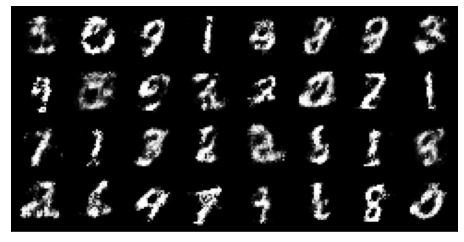

Epoch:17,   G_loss:1.7304107982720902,    D_loss:0.9137302218342641


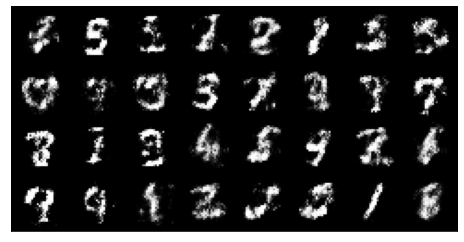

Epoch:18,   G_loss:1.826857509262272,    D_loss:0.9016123329843285


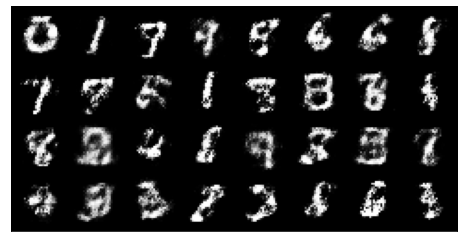

Epoch:19,   G_loss:1.840231968141568,    D_loss:0.899791031122716


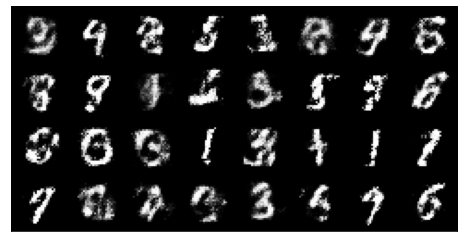

In [14]:
for epoch in range(20):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i, data in enumerate(trainLoader):
        X, _ = data
        X = X.view(X.size(0), -1).to(device)
        mb_size = X.size(0)
        
        one_labels = torch.ones(mb_size, 1).to(device)
        zero_labels = torch.zeros(mb_size, 1).to(device)
        
        z = torch.randn(mb_size, Z_dim).to(device)
        
        D_real = D(X)
        D_fake = D(G(z))
        
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_loss = D_real_loss + D_fake_loss
        
        d_opt.zero_grad()
        D_loss.backward()
        d_opt.step()
        
        z = torch.randn(mb_size, Z_dim).to(device)
        D_fake = D(G(z))
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        
        g_opt.zero_grad()
        G_loss.backward()
        g_opt.step()
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1)))
    
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 28, 28).cpu()
    #imshow(samples)


torch.Size([64, 100])
torch.Size([64, 784])


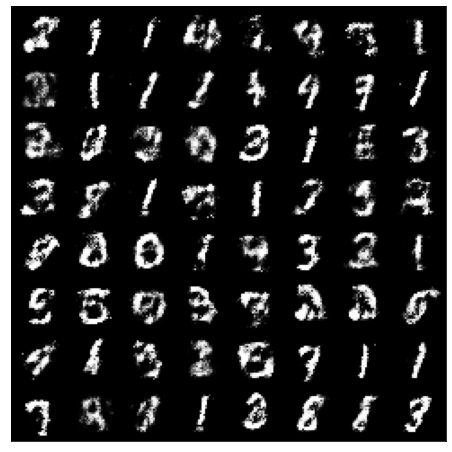

In [28]:

z = torch.randn(64, 100).to(device)
print(z.shape)
sample = G(z)
print(sample.shape)
sample = sample.view(sample.size(0), 1, 28, 28).cpu()
imshow(sample.detach())
